In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install tensorflow

     |████████████████████████████████| 462 kB 5.2 MB/s 


In [3]:
import os
from keras.models import Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
import tensorflow as tf
from pathlib import Path
import numpy as np

In [4]:
! pip install livelossplot

     |████████████████████████████████| 793 kB 6.9 MB/s 
     |████████████████████████████████| 381 kB 42.5 MB/s 
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting uninstall: ipython
    Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 3.0.29 which is incompatible.
google-colab 1.0.0 requires ipython~=5.5.0, but you have ipython 7.32.0 which is incompatible.


In [5]:

train_generator = ImageDataGenerator(rotation_range=90, 
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5, 
                                     height_shift_range=0.5,
                           
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     validation_split=0.15,
                                     preprocessing_function=preprocess_input) # VGG16 preprocessing

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) 

In [6]:
download_dir = Path('/content/drive/MyDrive')


train_data_dir = download_dir/'SIH-dataset/images/train'
test_data_dir = download_dir/'SIH-dataset/images/test'

In [7]:
class_subset = sorted(os.listdir(download_dir/'SIH-dataset/images/train'))[:18]
traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='training',
                                               batch_size=64, 
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='validation',
                                               batch_size=64,
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(224, 224),
                                             class_mode=None,
                                             classes=class_subset,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)
print(class_subset)

Found 1888 images belonging to 18 classes.
Found 324 images belonging to 18 classes.
Found 730 images belonging to 18 classes.
['Ajanta Caves', 'Champaner-Pavagadh Archaelogical Park', 'Chittaurgarh Fort', 'Ellora Caves', 'Fatehpur Sikri', 'India gate pics', 'Khajuraho', 'Pattadakal', 'Sun Temple Konark', 'alai_darwaza', 'alai_minar', 'golden temple', 'hawa mahal pics', 'iron_pillar', 'jamali_kamali_tomb', 'qutub_minar', 'tajmahal', 'tanjavur temple']


In [8]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):

    conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    

    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    model = Model(inputs=conv_base.input, outputs=output_layer)

    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [9]:
input_shape = (224, 224, 3)
optimizer = tf.keras.optimizers.Adam(epsilon=0.001)
n_classes=18

n_steps = traingen.samples // 64
n_val_steps = validgen.samples // 64
n_epochs = 50

vgg_model = create_model(input_shape, n_classes, optimizer, fine_tune=0)

58900480/58889256 [==============================] - 0s 0us/step


In [10]:
from livelossplot.inputs.keras import PlotLossesCallback

plot_loss_1 = PlotLossesCallback()

tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

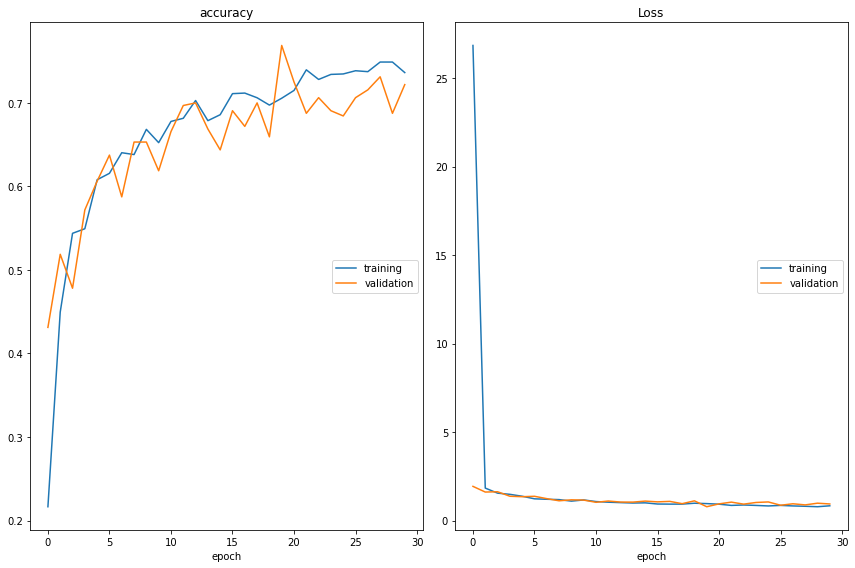

accuracy
	training         	 (min:    0.217, max:    0.749, cur:    0.736)
	validation       	 (min:    0.431, max:    0.769, cur:    0.722)
Loss
	training         	 (min:    0.780, max:   26.843, cur:    0.832)
	validation       	 (min:    0.779, max:    1.930, cur:    0.936)
29/29 [==============================] - 79s 3s/step - loss: 0.8324 - accuracy: 0.7363 - val_loss: 0.9363 - val_accuracy: 0.7219
CPU times: user 40min 37s, sys: 1min 28s, total: 42min 5s
Wall time: 53min 20s


In [11]:
%%time 

vgg_history = vgg_model.fit(traingen,
                            batch_size=64,
                            epochs=n_epochs,
                            validation_data=validgen,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
                            verbose=1)

In [12]:
tf.keras.models.save_model(vgg_model,'my_model.hdf5')

In [13]:
# Generate predictions
vgg_model.load_weights('tl_model_v1.weights.best.hdf5') # initialize the best trained weights

true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg_preds = vgg_model.predict(testgen)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)

In [14]:
from sklearn.metrics import accuracy_score

vgg_acc = accuracy_score(true_classes, vgg_pred_classes)
print("VGG16 Model Accuracy without Fine-Tuning: {:.2f}%".format(vgg_acc * 100))

VGG16 Model Accuracy without Fine-Tuning: 69.32%


Lets fine tune our model


In [19]:
# Reset our image data generators
traingen.reset()
validgen.reset()
testgen.reset()

# Use a smaller learning rate
optim_2 = tf.keras.optimizers.Adam(epsilon=0.0001)
# Re-compile the model, this time leaving the last 2 layers unfrozen for Fine-Tuning
vgg_model_ft = create_model(input_shape, n_classes, optim_2, fine_tune=1)

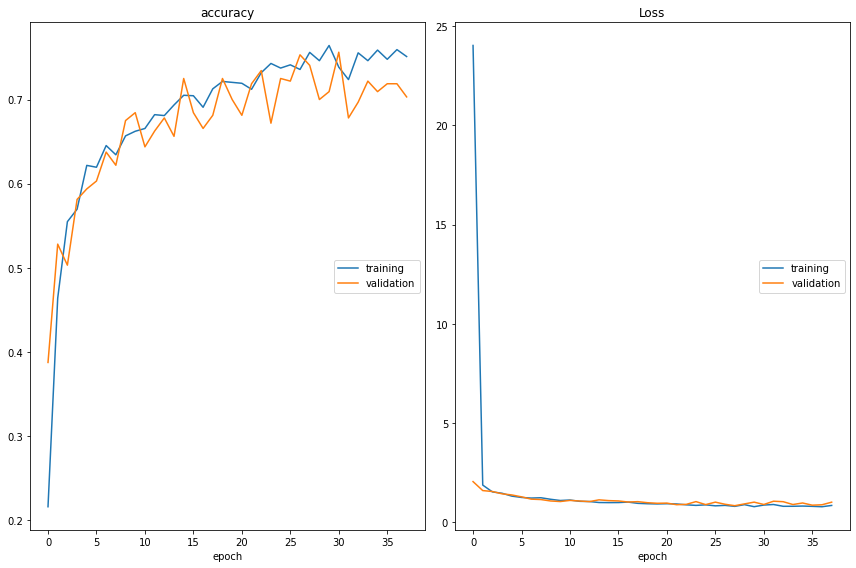

accuracy
	training         	 (min:    0.216, max:    0.764, cur:    0.751)
	validation       	 (min:    0.387, max:    0.756, cur:    0.703)
Loss
	training         	 (min:    0.772, max:   24.033, cur:    0.837)
	validation       	 (min:    0.824, max:    2.039, cur:    1.002)
29/29 [==============================] - 79s 3s/step - loss: 0.8370 - accuracy: 0.7511 - val_loss: 1.0017 - val_accuracy: 0.7031
CPU times: user 51min 14s, sys: 1min 33s, total: 52min 47s
Wall time: 51min 36s


In [20]:
%%time

plot_loss_2 = PlotLossesCallback()

# Retrain model with fine-tuning
vgg_ft_history = vgg_model_ft.fit(traingen,
                                  batch_size=64,
                                  epochs=n_epochs,
                                  validation_data=validgen,
                                  steps_per_epoch=n_steps, 
                                  validation_steps=n_val_steps,
                                  callbacks=[tl_checkpoint_1, early_stop, plot_loss_2],
                                  verbose=1)

In [29]:
tf.keras.models.save_model(vgg_model_ft,'my_model2.hdf5')

In [33]:
# Generate predictions
true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg_preds_ft = vgg_model_ft.predict(testgen)
vgg_pred_classes = np.argmax(vgg_preds_ft, axis=1)

In [34]:
from sklearn.metrics import accuracy_score

vgg_acc = accuracy_score(true_classes, vgg_pred_classes)
print("VGG16 Model Accuracy without Fine-Tuning: {:.2f}%".format(vgg_acc * 100))

VGG16 Model Accuracy without Fine-Tuning: 69.32%
